In [1]:
# import all necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LassoCV

import warnings
warnings.filterwarnings("ignore")

# Initial Exploratory Data Analysis on Raw Data

This section focuses on visualizing the overall dataset and produce EDA graphs such as daily overall confirmed cases and daily overall confirmed deaths in the US.

In [2]:
# read in the respective data to be used in initial EDA
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

In [3]:
# this function will take in a dataframe in the form of 'time_series_covid19_confirmed_US.csv' or 
# 'time_series_covid19_deaths_US.csv' and output a dataframe with number of respective cases daily in the US

def overall(df):
    only_dates = df.filter(regex = f'\d+\/\d+\/\d+')
    total_confirmed_daily = only_dates.sum(axis = 0)
    total_confirmed_daily_df = total_confirmed_daily.to_frame()
    total_confirmed_daily_newdf = total_confirmed_daily_df.reset_index()
    total_confirmed_daily_newdf.columns = ['Date', 'Respective Cases']
    total_confirmed_daily_newdf['Date'] = pd.to_datetime(total_confirmed_daily_newdf['Date'])
    return total_confirmed_daily_newdf

In [4]:
# create dataframes with total number of cases daily in the US

overall_confirmed = overall(confirmed)
overall_deaths = overall(deaths)

In [5]:
overall_confirmed.head()

Date  Respective Cases
0 2020-01-22                 1
1 2020-01-23                 1
2 2020-01-24                 2
3 2020-01-25                 2
4 2020-01-26                 5

In [6]:
overall_deaths.head()

Date  Respective Cases
0 2020-01-22                 0
1 2020-01-23                 0
2 2020-01-24                 0
3 2020-01-25                 0
4 2020-01-26                 0

Text(0, 0.5, 'Number of Confirmed Cases')

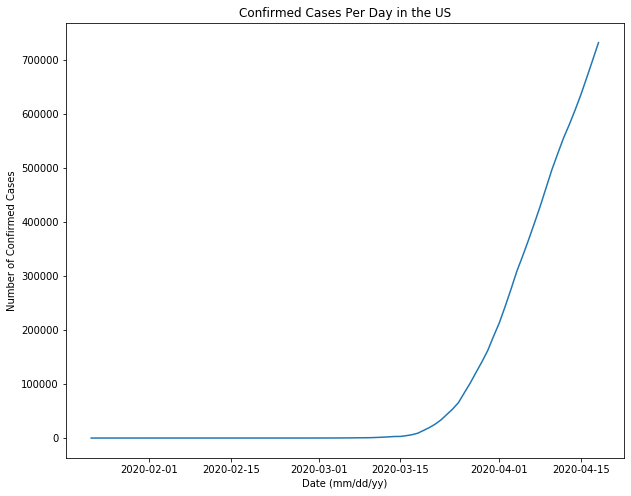

In [7]:
# plots the overall confirmed cases daily in the US
fig, axes = plt.subplots(figsize = (10,8))
plt.plot(overall_confirmed['Date'], overall_confirmed['Respective Cases'], label = 'Confirmed Cases')
plt.title('Confirmed Cases Per Day in the US')
plt.xlabel('Date (mm/dd/yy)')
plt.ylabel('Number of Confirmed Cases')

Text(0, 0.5, 'Number of Confirmed Deaths')

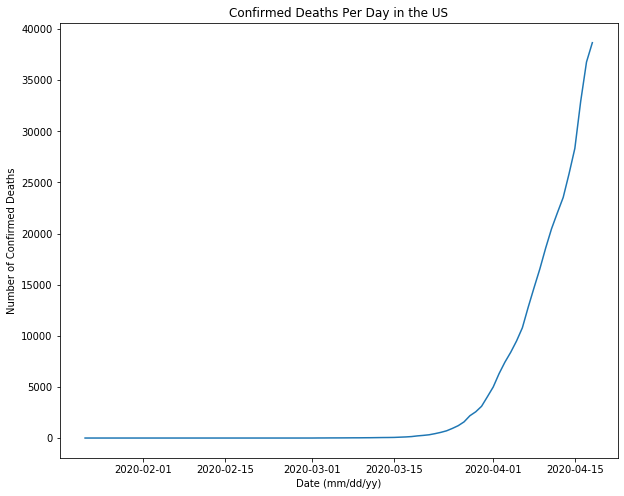

In [8]:
# plots the overall confirmed deaths daily in the US
fig, axes = plt.subplots(figsize = (10,8))
plt.plot(overall_deaths['Date'], overall_deaths['Respective Cases'], label = 'Death Toll')
plt.title('Confirmed Deaths Per Day in the US')
plt.xlabel('Date (mm/dd/yy)')
plt.ylabel('Number of Confirmed Deaths')

# Importing and Cleaning Data

In [9]:
# Cleaning Confirmed Cumulative Deaths
# FIPS and Admin2 contain some NaN values (mainly consists of prisons and territories), so threw all NaN rows out
# Dukes and Nantucket and Kasas City were the only real cities that had errors in data entry
US_Deaths = pd.read_csv('time_series_covid19_deaths_US.csv')
US_Deaths = US_Deaths.loc[False == US_Deaths.isnull().any(axis=1)]
US_Deaths['FIPS'] = US_Deaths['FIPS'].astype(int) # Converted FIPS to int for merging of tables
US_Deaths = US_Deaths.iloc[:, list(range(8)) + list(np.arange(-7,0))] # We only care about the last week of deaths
print('Number of Counties in Deaths Table: ', US_Deaths.shape[0])
US_Deaths.head()

Number of Counties in Deaths Table:  3244


UID iso2 iso3  code3  FIPS   Admin2 Province_State Country_Region  \
5  84001001   US  USA    840  1001  Autauga        Alabama             US   
6  84001003   US  USA    840  1003  Baldwin        Alabama             US   
7  84001005   US  USA    840  1005  Barbour        Alabama             US   
8  84001007   US  USA    840  1007     Bibb        Alabama             US   
9  84001009   US  USA    840  1009   Blount        Alabama             US   

   4/12/20  4/13/20  4/14/20  4/15/20  4/16/20  4/17/20  4/18/20  
5        1        1        1        1        1        2        2  
6        1        1        2        2        2        2        2  
7        0        0        0        0        0        0        0  
8        0        0        0        0        0        0        0  
9        0        0        0        0        0        0        0

In [10]:
# Dropped FIPS with 60020, 69120, and CountyName Cocos Island - not in cumulative deaths dataset
# Dropped FIPS with City1 and City 2 (NYC and Kansas City) - filled with NAN values
Counties = pd.read_csv('abridged_couties.csv')
FIPS_to_drop = ['60020', '69120', 'City1', 'City2']
County_names_to_drop = ['Cocos Island']
Clean_Counties = Counties.loc[False == Counties.isin({'countyFIPS': FIPS_to_drop})['countyFIPS'],:]
Clean_Counties = Clean_Counties.loc[False == Clean_Counties.isin({'CountyName': County_names_to_drop})['CountyName'],:]
Clean_Counties['countyFIPS'] = Clean_Counties['countyFIPS'].astype(int) # Connverted FIPS to int for merging of tables
print('Number of Counties in County Info Table: ', Clean_Counties.shape[0])
Clean_Counties.head()

Number of Counties in County Info Table:  3236


countyFIPS  STATEFP  COUNTYFP CountyName StateName    State        lat  \
0        1001      1.0       1.0    Autauga        AL  Alabama  32.540091   
1        1003      1.0       3.0    Baldwin        AL  Alabama  30.738314   
2        1005      1.0       5.0    Barbour        AL  Alabama  31.874030   
3        1007      1.0       7.0       Bibb        AL  Alabama  32.999024   
4        1009      1.0       9.0     Blount        AL  Alabama  33.990440   

         lon  POP_LATITUDE  POP_LONGITUDE  ... >500 gatherings public schools  \
0 -86.645649     32.500389     -86.494165  ...        737497.0       737500.0   
1 -87.726272     30.548923     -87.762381  ...        737497.0       737500.0   
2 -85.397327     31.844036     -85.310038  ...        737497.0       737500.0   
3 -87.125260     33.030921     -87.127659  ...        737497.0       737500.0   
4 -86.562711     33.955243     -86.591491  ...        737497.0       737500.0   

   restaurant dine-in  entertainment/gym  federal guidelines  \
0            737503.0           737512.0            737500.0   
1            737503.0           737512.0            737500.0   
2            737503.0           737512.0            737500.0   
3            737503.0           737512.0            737500.0   
4            737503.0           737512.0            737500.0   

   foreign travel ban  SVIPercentile  HPSAShortage  HPSAServedPop  \
0            737495.0         0.4354           NaN            NaN   
1            737495.0         0.2162           NaN            NaN   
2            737495.0         0.9959          6.08         5400.0   
3            737495.0         0.6003          2.75        14980.0   
4            737495.0         0.4242          7.21        31850.0   

   HPSAUnderservedPop  
0                 NaN  
1                 NaN  
2             18241.0  
3              6120.0  
4             25233.0  

[5 rows x 87 columns]

Our reponse variable was calculated from the merged deaths and county matrix and is a measure of how fast the virus is spreading relative to the county population. The formula is:
$$Spread Factor = \frac{Deaths\:between\:4/12/20\:and\:4/18/20}{7} $$

In [11]:
# Merging Deaths and County Information.
# Upon left merge, I found that there is not data for deaths in guam, so had to drop ~80 entries. 
# Dropped one county in Alaska due to error in data.
# Statistic is: (average deaths per day for the last week)/(population in 2018)
Feature_matrix = Clean_Counties.merge(US_Deaths, how='inner', left_on='countyFIPS', right_on='FIPS')
Feature_matrix = Feature_matrix.drop(columns=['UID', 'iso2', 'code3', 'Admin2', 'Province_State', 
                                              'Country_Region', 'iso3', 'FIPS'])
Feature_matrix['Rise in Deaths (per day)'] = (Feature_matrix['4/18/20']-Feature_matrix['4/12/20'])/7
Feature_matrix['Spread Factor'] = Feature_matrix['Rise in Deaths (per day)']/Feature_matrix[
    'PopulationEstimate2018']
print('Number of Counties in Merged Table: ', Feature_matrix.shape[0])
Feature_matrix.isna().sum().sort_values(ascending=False).head(30)
# There seem to be many missing values in many in the merged counties table.

Number of Counties in Merged Table:  3140


3-YrMortalityAge1-4Years2015-17      3075
mortality2015-17Estimated            3045
3-YrMortalityAge5-14Years2015-17     3045
3-YrMortalityAge<1Year2015-17        2672
3-YrMortalityAge15-24Years2015-17    2514
3-YrMortalityAge25-34Years2015-17    2183
3-YrMortalityAge35-44Years2015-17    1842
3-YrDiabetes2015-17                  1719
HPSAUnderservedPop                   1101
HPSAServedPop                        1101
HPSAShortage                         1101
3-YrMortalityAge45-54Years2015-17    1033
stay at home                          489
3-YrMortalityAge55-64Years2015-17     465
3-YrMortalityAge65-74Years2015-17     306
3-YrMortalityAge75-84Years2015-17     214
3-YrMortalityAge85+Years2015-17       157
>500 gatherings                       118
>50 gatherings                        118
State                                  66
lat                                    66
lon                                    66
entertainment/gym                      65
dem_to_rep_ratio                  

In [12]:
# Finding counties with more than one death from the virus
Limited_Feature_Matrix = Feature_matrix.loc[Feature_matrix.iloc[:,-3]>1,:]
print('Number of Counties with More than One Death: ', Limited_Feature_Matrix.shape[0])
features_to_drop = ['3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17', 
                    'mortality2015-17Estimated', 'HPSAShortage', 'HPSAUnderservedPop', 'HPSAServedPop',
                    '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge15-24Years2015-17', 
                    '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17', 
                    '3-YrDiabetes2015-17', '3-YrMortalityAge45-54Years2015-17', 'lat', 'State', 'lon',
                    '3-YrMortalityAge55-64Years2015-17', '3-YrMortalityAge75-84Years2015-17', 
                    '3-YrMortalityAge65-74Years2015-17', '3-YrMortalityAge85+Years2015-17']
Limited_Feature_Matrix.isna().sum().sort_values(ascending=False).head(30)
# Number of missing values significantly decreases for counties with more than one death


Number of Counties with More than One Death:  801


3-YrMortalityAge1-4Years2015-17      739
3-YrMortalityAge5-14Years2015-17     709
mortality2015-17Estimated            709
HPSAShortage                         443
HPSAUnderservedPop                   443
HPSAServedPop                        443
3-YrMortalityAge<1Year2015-17        405
3-YrMortalityAge15-24Years2015-17    325
3-YrMortalityAge25-34Years2015-17    206
3-YrMortalityAge35-44Years2015-17    125
3-YrDiabetes2015-17                  123
stay at home                          46
3-YrMortalityAge45-54Years2015-17     28
lat                                    7
State                                  7
lon                                    7
>500 gatherings                        5
>50 gatherings                         5
3-YrMortalityAge55-64Years2015-17      4
3-YrMortalityAge75-84Years2015-17      3
entertainment/gym                      2
3-YrMortalityAge65-74Years2015-17      2
3-YrMortalityAge85+Years2015-17        1
Smokers_Percentage                     0
#ICU_beds       

In [13]:
# Getting rid of features with many NaN values as seen above
# Getting rid of useless features such as lat and long
# Fill in rest of NaN values with mean of the column (~50 values were filled in with this method)
# Coverting proleptic Gregorian ordinal date to days elapsed from March 1, 2020 (for 'Stay at home' column, etc.)
pd.set_option('display.max_columns', None)
useless_features = ['STATEFP', 'COUNTYFP', 'POP_LATITUDE', 'POP_LONGITUDE', 'CensusRegionName',
                    'CensusDivisionName']
Clean_Feature_Matrix = Limited_Feature_Matrix.drop(columns=features_to_drop+useless_features)
Clean_Feature_Matrix = Clean_Feature_Matrix.fillna(Clean_Feature_Matrix.median())
ordinal_date_features = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
                         'restaurant dine-in', 'entertainment/gym', 'federal guidelines', 'foreign travel ban']
Clean_Feature_Matrix[ordinal_date_features] = Clean_Feature_Matrix[ordinal_date_features].astype(int)
Clean_Feature_Matrix = Clean_Feature_Matrix.reset_index().drop(columns=['index'])
for i in ordinal_date_features:
    Clean_Feature_Matrix[i] = Clean_Feature_Matrix[i].apply(datetime.fromordinal)
dummy = pd.Series(['3/01/2020']*Clean_Feature_Matrix.shape[0])
baseline = pd.to_datetime(dummy)
for i in ordinal_date_features:
    Clean_Feature_Matrix[i] = (Clean_Feature_Matrix[i] - baseline).dt.days
Clean_Feature_Matrix

countyFIPS  CountyName StateName  Rural-UrbanContinuumCode2013  \
0          1001     Autauga        AL                           2.0   
1          1003     Baldwin        AL                           3.0   
2          1015     Calhoun        AL                           3.0   
3          1017    Chambers        AL                           6.0   
4          1047      Dallas        AL                           4.0   
..          ...         ...       ...                           ...   
796       55127    Walworth        WI                           4.0   
797       55131  Washington        WI                           1.0   
798       55133    Waukesha        WI                           1.0   
799        8014  Broomfield        CO                           1.0   
800       12086  Miami-Dade        FL                           1.0   

     PopulationEstimate2018  PopTotalMale2017  PopTotalFemale2017  \
0                   55601.0           27007.0             28497.0   
1                  218022.0          103225.0            109403.0   
2                  114277.0           55149.0             59579.0   
3                   33615.0           16140.0             17573.0   
4                   38310.0           18089.0             21126.0   
..                      ...               ...                 ...   
796                103718.0           51469.0             51613.0   
797                135693.0           67216.0             67885.0   
798                403072.0          196932.0            203689.0   
799                 69267.0           33991.0             34350.0   
800               2761581.0         1336041.0           1415755.0   

     FracMale2017  PopulationEstimate65+2017  PopulationDensityperSqMile2010  \
0        0.486578                     8392.0                            91.8   
1        0.485472                    42413.0                           114.7   
2        0.480693                    19862.0                           195.7   
3        0.478747                     6432.0                            57.4   
4        0.461278                     6799.0                            44.8   
..            ...                        ...                             ...   
796      0.499302                    17627.0                           184.2   
797      0.497524                    23603.0                           306.2   
798      0.491567                    72379.0                           709.4   
799      0.497373                     9055.0                          1691.9   
800      0.485516                   439045.0                          1315.5   

     CensusPopulation2010  MedianAge2010  #EligibleforMedicare2018  \
0                 54571.0           37.0                   11439.0   
1                182265.0           41.1                   54145.0   
2                118572.0           38.2                   28487.0   
3                 34215.0           41.5                    9276.0   
4                 43820.0           37.7                   10286.0   
..                    ...            ...                       ...   
796              102228.0           38.1                   21838.0   
797              131887.0           40.9                   28476.0   
798              389891.0           42.0                   87752.0   
799               55889.0           36.4                   11808.0   
800             2496435.0           38.2                  479710.0   

     MedicareEnrollment,AgedTot2017  DiabetesPercentage  \
0                            8046.0                 9.9   
1                           41590.0                 8.5   
2                           20142.0                15.6   
3                            6342.0                17.5   
4                            6727.0                13.9   
..                              ...                 ...   
796                         17140.0                 6.4   
797                         23574.0              

In [14]:
# Making Sure there are no NaN values
Clean_Feature_Matrix.isna().sum().sort_values(ascending=False)

Spread Factor                       0
PopMale<52010                       0
#FTEHospitalTotal2017               0
TotalM.D.'s,TotNon-FedandFed2017    0
#HospParticipatinginNetwork2017     0
                                   ..
PopMale65-742010                    0
PopFmle65-742010                    0
PopMale75-842010                    0
PopFmle75-842010                    0
countyFIPS                          0
Length: 71, dtype: int64

In [15]:
# Removing columns that are not needed for further analysis, and exporting final, cleaned data
# Got rid of federal and foreign travel bans because they are the same for each county
Info = Clean_Feature_Matrix[['CountyName', 'StateName', '4/18/20']]
Data = Clean_Feature_Matrix.iloc[:,list(np.arange(3,62))+list(np.array([70]))]
Data = Data.drop(columns=['foreign travel ban', 'federal guidelines'])
Info.to_csv('Info.csv', index=False)
Data.to_csv('Data.csv', index=False)

# Analyzing Cleaned Data

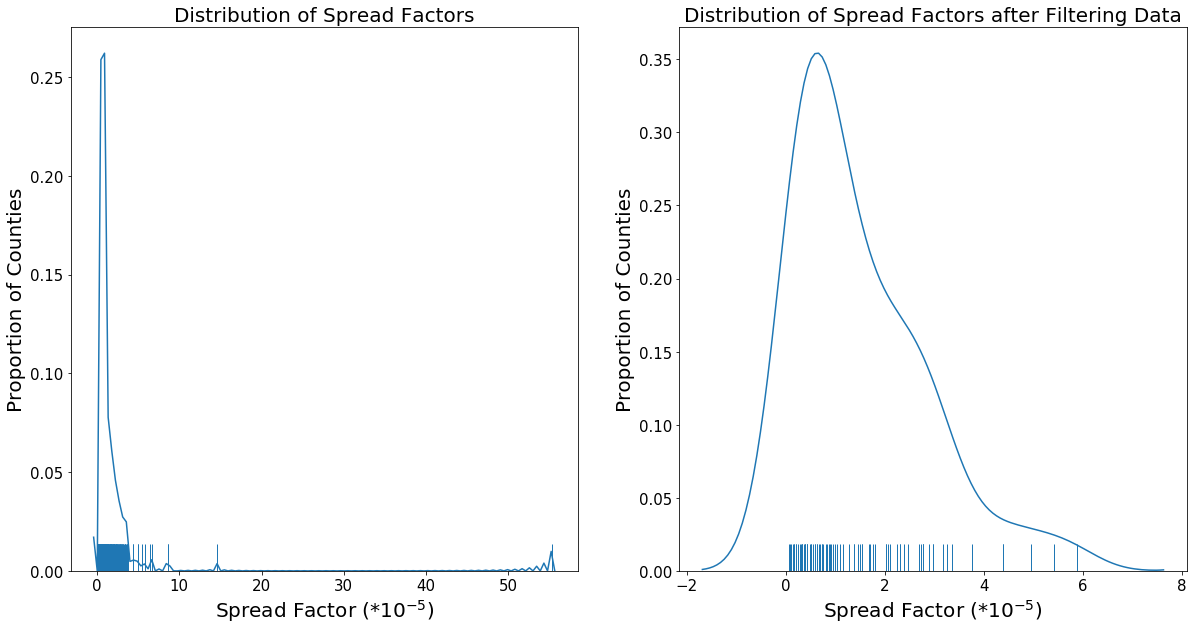

In [16]:
# Importing processed data
Info = pd.read_csv('Info.csv')
Data = pd.read_csv('Data.csv')
Data['Spread Factor'] = Data['Spread Factor']*100000 # Scaling the spread factor for easier analysis

fig = plt.figure(figsize=(20, 10)) # Plotting distribution of data before removing outliers
plt.subplot(1, 2, 1)
ax = sns.distplot(Data['Spread Factor'], rug=True, hist=False)
plt.title('Distribution of Spread Factors', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Spread Factor ($*10^{-5}$)', fontsize=20)
plt.ylabel('Proportion of Counties', fontsize=20)

drop_index = Data.loc[Data['Spread Factor']>10].index # Removing outliers
Data = Data.drop(index=drop_index)
Info = Info.drop(index=drop_index)
Info = Info.loc[Info['4/18/20']>50] # Only considering counties with more than 50 deaths for representative data.
Data = Data.loc[Info.index, :]
pd.set_option('display.max_columns', None)

plt.subplot(1, 2, 2) # Plotting distribution of data after removing outliers
ax = sns.distplot(Data['Spread Factor'], rug=True, hist=False)
plt.title('Distribution of Spread Factors after Filtering Data', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Spread Factor ($*10^{-5}$)', fontsize=20)
plt.ylabel('Proportion of Counties', fontsize=20)
plt.savefig('Distribution_of_Spread_Factors.png')

Note that since we are eliminating all counties with less than 50 deaths from both the training and test dataset, our model will not be able to predict counties that have had very few deaths. We chose this threshold because counties with a very small number of deaths were found to be overly-sensitive to certain features. Upon model development, we go back and check that the model does indeed predict counties with high spread factors correctly.

In [17]:
# Splitting the data into test and training sets
X_train, X_test, y_train, y_test =train_test_split(Data.iloc[:,0:-1],Data.iloc[:,-1],test_size=0.3,random_state=42)
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

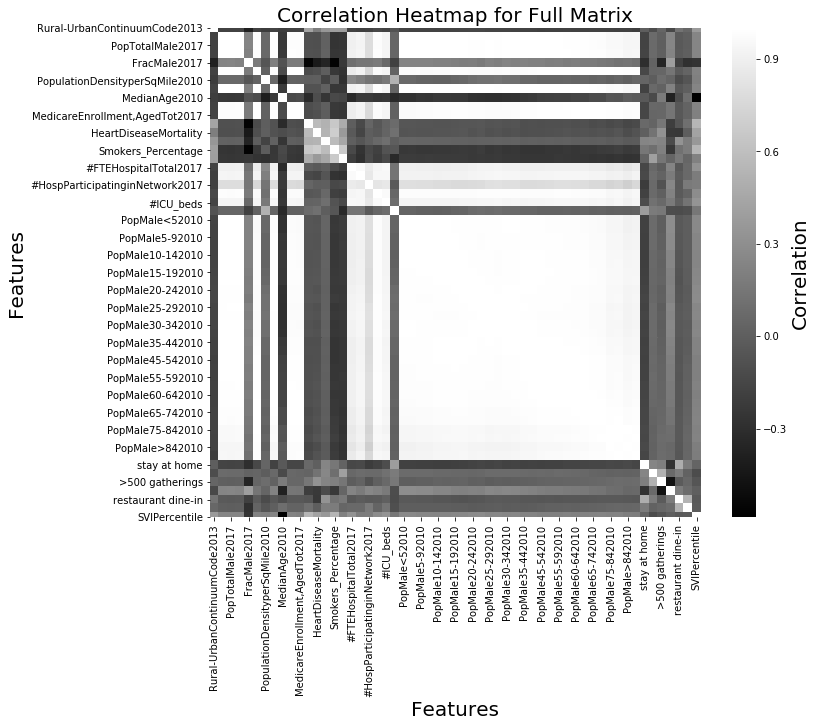

In [18]:
# Plotting correlation heatmap for all of the features
graphing = X_train.corr()
graphing.head()
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(graphing,cmap='gray',cbar_kws={'label': 'Correlation'});
plt.xlabel('Features', fontsize=20);
plt.ylabel('Features', fontsize=20);
ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title('Correlation Heatmap for Full Matrix', fontsize=20);

As we might have expected, the population features seem to be heavily correlated. We thus remove several of the population features, as they present redundant information. We then found that there were two additional main sources of correlation. In the first plot shown below, the large white square towards the upper left is a representation of the health of the county, while the large white square towards the center of the heatmap is a representation of the hospital network in the county. We train and develop two different models - one with the extended feature list, and the other with a simplified feature list. Each of the features and their correlations with each other can be seen below.

In [19]:
# Picking out features that are not as correlated to each other
Comprehensive_Features = [0, 1, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 50, 51, 52, 53, 54, 55, 56]
Less_Features = [0, 1, 6, 8, 11, 16, 21, 50, 51, 52, 53, 54, 55, 56] 
X_train_less = X_train.iloc[:,Less_Features]
X_test_less = X_test.iloc[:,Less_Features]

X_train_more = X_train.iloc[:,Comprehensive_Features]
X_test_more = X_test.iloc[:,Comprehensive_Features]

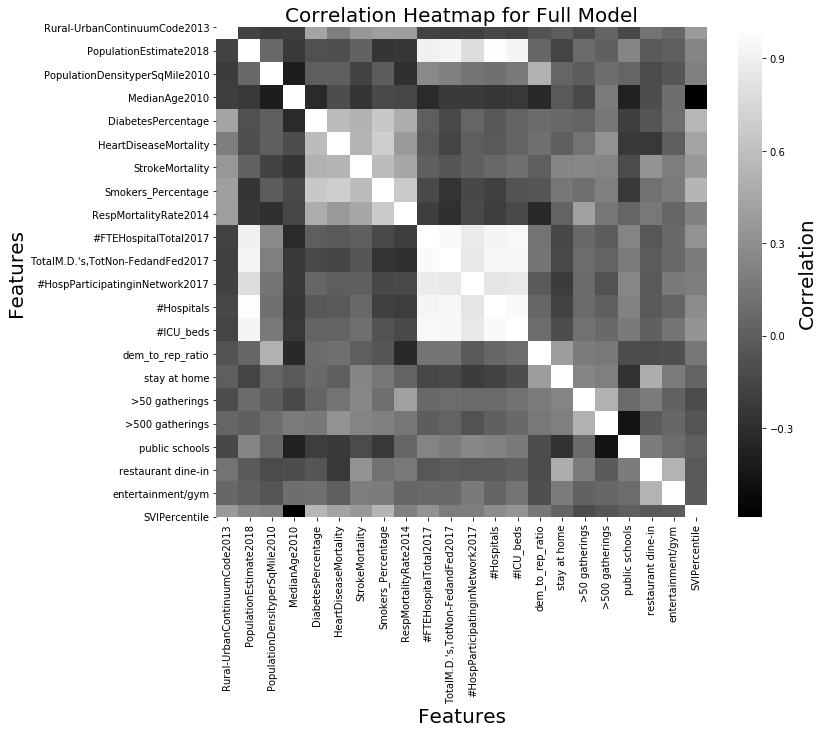

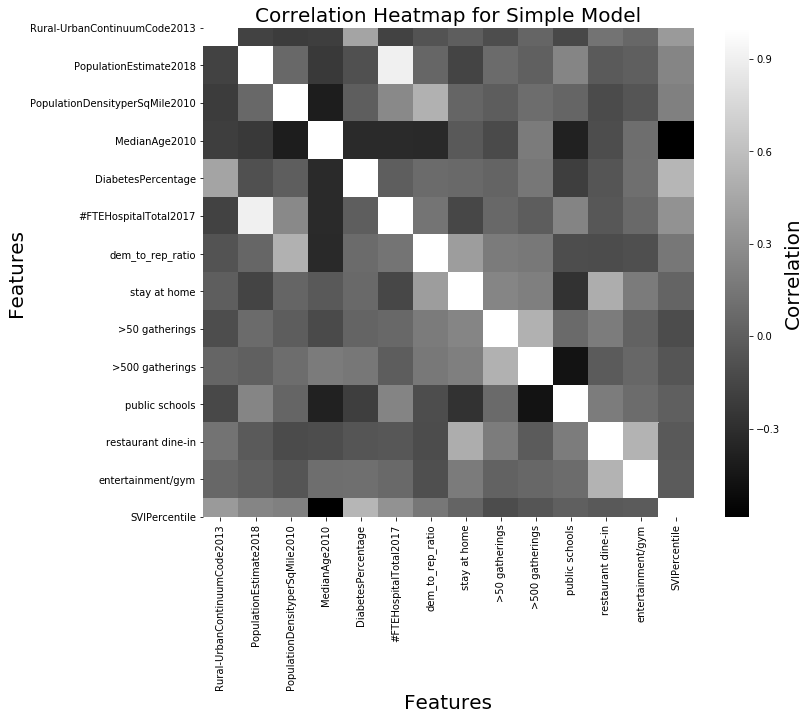

In [20]:
# Plotting Full Model Feature Matrix
f, ax = plt.subplots(figsize=(11, 9))
graphing = X_train_more.corr()
ax = sns.heatmap(graphing,cmap='gray',cbar_kws={'label': 'Correlation'});
plt.xlabel('Features', fontsize=20);
plt.ylabel('Features', fontsize=20);
plt.title('Correlation Heatmap for Full Model', fontsize=20);
ax.figure.axes[-1].yaxis.label.set_size(20)

# Plotting Simple Model Feature Matrix
f, ax = plt.subplots(figsize=(11, 9))
graphing = X_train_less.corr()
ax = sns.heatmap(graphing,cmap='gray',cbar_kws={'label': 'Correlation'});
plt.title('Correlation Heatmap for Simple Model', fontsize=20);
plt.xlabel('Features', fontsize=20);
plt.ylabel('Features', fontsize=20);
ax.figure.axes[-1].yaxis.label.set_size(20)

# Fitting and Evaluating a Lasso model to both feature matrices

In [21]:
# The RMSE will be our metric to evaluate the accuracy of both models
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

In [22]:
# Performing cross validation to find the best alpha parameter for each model
lasso_model_simple = Lasso() # Initializing model
lasso_model_full = Lasso()
alphas = np.linspace(0.00001, 1, 100) # Alphas to test
cv_values_simple = [] # Initialize array to store errors
cv_values_full = []
train_values_simple = []
train_values_full = []

for alpha in alphas: # Finding CV and train errors for each alpha value
    # Setting alpha parameter
    lasso_model_simple.set_params(alpha=alpha)
    lasso_model_full.set_params(alpha=alpha)
    # Finding average CV error
    cv_values_simple.append(np.mean(cross_val_score(lasso_model_simple, X_train_less, y_train, scoring=rmse_score)))
    cv_values_full.append(np.mean(cross_val_score(lasso_model_full, X_train_more, y_train, scoring=rmse_score)))
    # Fitting model
    lasso_model_simple.fit(X_train_less, y_train)
    lasso_model_full.fit(X_train_more, y_train)
    # Finding training error
    train_values_simple.append(rmse_score(lasso_model_simple, X_train_less, y_train))
    train_values_full.append(rmse_score(lasso_model_full, X_train_more, y_train))

In [23]:
# Plotting CV and Training Errors for Simple Model
fig = go.Figure()
fig.add_trace(go.Scatter(x = alphas, y = train_values_simple, mode="lines+markers", name="Train"))
fig.add_trace(go.Scatter(x = alphas, y = cv_values_simple, mode="lines+markers", name="CV"))
fig.update_layout(xaxis_title=r"$\alpha$", yaxis_title="CV RMSE", title_text='Training and CV Errors for Simple Model', title_x=0.5)
fig.update_layout()

In [24]:
# Plotting CV and Training Errors for Full Model
fig = go.Figure()
fig.add_trace(go.Scatter(x = alphas, y = train_values_full, mode="lines+markers", name="Train"))
fig.add_trace(go.Scatter(x = alphas, y = cv_values_full, mode="lines+markers", name="CV"))
fig.update_layout(xaxis_title=r"$\alpha$", yaxis_title="CV RMSE", title_text='Training and CV Errors for Full Model', title_x=0.5)
fig.update_layout()

Both model have the expected trends of CV and training error as a function of the alpha parameter. The best alpha parameter is one that minimizes the CV error.

In [25]:
alpha_simple = alphas[np.argmin(cv_values_simple)] # Finding optimal alpha values for each model
alpha_full = alphas[np.argmin(cv_values_full)]
lasso_model_final_simple = Lasso() # Fitting each model with optimal alpha value
lasso_model_final_simple.set_params(alpha=alpha_simple)
lasso_model_final_simple.fit(X_train_less, y_train)
lasso_model_final_full = Lasso()
lasso_model_final_full.set_params(alpha=alpha_full)
lasso_model_final_full.fit(X_train_more, y_train)
# Calculating RMSE test error for both models
error_test_simple = np.sqrt(np.mean((y_test - lasso_model_final_simple.predict(X_test_less))**2))
error_test_full = np.sqrt(np.mean((y_test - lasso_model_final_full.predict(X_test_more))**2))
print('RMSE Test Error for Simple Model: ', error_test_simple)
print('RMSE Test Error for Full Model: ', error_test_full)

RMSE Test Error for Simple Model:  0.7929558276212745
RMSE Test Error for Full Model:  0.8650805076549998


Both errors are reasonable. They indicate the our models are performing adequately; however, they are not very accurate. The full model performs worse than the simple model. This might be due to the fact that the full model has features that are redundant.

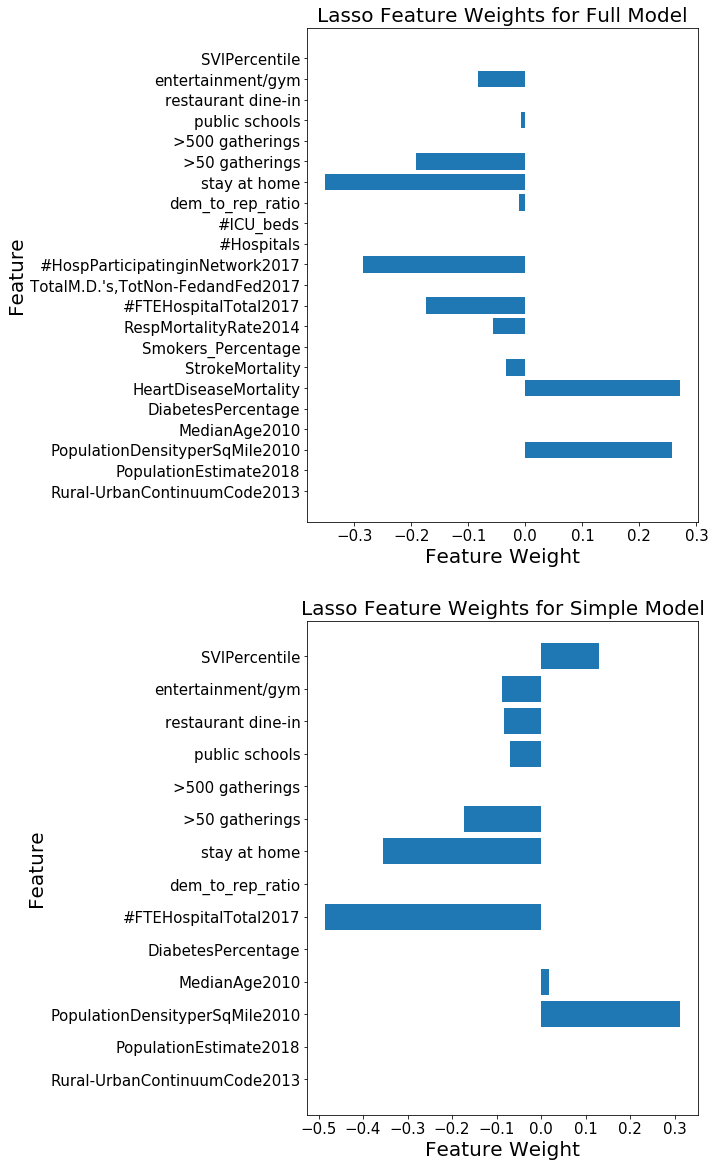

In [26]:
# Plotting weights of each feature for each model
fig = plt.figure(figsize=(7, 20))

plt.subplot(2, 1, 1) # Plotting full model
plt.barh(X_train_more.columns, lasso_model_final_full.coef_)
plt.title('Lasso Feature Weights for Full Model', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Feature Weight', fontsize=20);
plt.ylabel('Feature', fontsize=20);

plt.subplot(2, 1, 2) # Plotting simple model
plt.barh(X_train_less.columns, lasso_model_final_simple.coef_)
plt.title('Lasso Feature Weights for Simple Model', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Feature Weight', fontsize=20);
plt.ylabel('Feature', fontsize=20);

As we might have expected, some of the most important features in both models are 'Stay at Home', 'Population Density', 'Hospital Total' (a measure of the quality of the hosipals in the county), and 'Gatherings With > 50 People'. Some of the redundant features in the full model have starkly different weights (i.e. 'Heart Disease Mortality' and 'Diabetes Percentage'). This might be one of the reasons why the full model is not performing as well and the simple model.

# Classification Analysis Method 1: Using the Top 3 Features From Lasso Regression Model

K-means clustering will be used to find optimal number of clusterings for classification purposes. Afterwards, the data is then assigned according to the previous findings and a KNN classification model will be trained based on the top 3 features from the lasso model.

In [27]:
# from the lasso model, lets pick the top three features as decided by simple lasso model

X_train_top_3 = X_train_less.loc[:,['stay at home', '#FTEHospitalTotal2017', 'PopulationDensityperSqMile2010']]
X_test_top_3 = X_test_less.loc[:,['stay at home', '#FTEHospitalTotal2017', 'PopulationDensityperSqMile2010']]

X_train_top_3.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010
517     -0.459746              -0.085970                       -0.539807
409      0.168200              -0.582484                       -0.211527
495     -0.773719              -0.246136                        0.114197
150      3.307928              -0.583046                       -0.109455
386      0.168200               1.729591                        3.795025

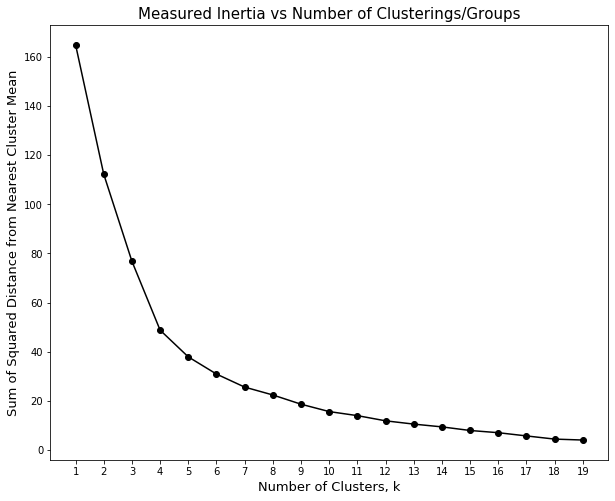

In [28]:
# perform k-means clustering on just these 3 features to see if there is any inherent grouping
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# first we need to find the optimal k value by plotting inertia vs k 

ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_train_top_3)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# plot the inertia vs k plot
fig, axes = plt.subplots(figsize = (10,8))
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of Clusters, k', fontsize = 13)
plt.ylabel('Sum of Squared Distance from Nearest Cluster Mean', fontsize = 13)
plt.xticks(ks)
plt.title('Measured Inertia vs Number of Clusterings/Groups', fontsize = 15)
plt.show()

Seems like 4 clusters is the most optimal clustering group to make so let's try making 4 clusters and see what it looks like. 

In [29]:
# create a specific cluster model of 4 and attach predicted clusterings onto feature dataframe

cluster_model = KMeans(n_clusters = 4, init = 'random', random_state = 0).fit(X_train_top_3)
prediction = cluster_model.predict(X_train_top_3)
X_train_top_3_pred = X_train_top_3.copy()
X_train_top_3_pred['Class'] = prediction
X_train_top_3_pred.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010  \
517     -0.459746              -0.085970                       -0.539807   
409      0.168200              -0.582484                       -0.211527   
495     -0.773719              -0.246136                        0.114197   
150      3.307928              -0.583046                       -0.109455   
386      0.168200               1.729591                        3.795025   

     Class  
517      3  
409      3  
495      3  
150      0  
386      2

In [30]:
# visualizing clusterings made on 3d graph

import plotly.express as px
fig = px.scatter_3d(X_train_top_3_pred, x='stay at home', y='#FTEHospitalTotal2017', z='PopulationDensityperSqMile2010',
              color='Class')
fig.show()

In [31]:
# create a df that has spread factor and class prediction

Y_train_pred = y_train.to_frame().copy()
Y_train_pred['Class'] = prediction
Y_train_pred.head()

Spread Factor  Class
517       0.900896      3
409       2.727282      3
495       2.066189      3
150       0.339747      0
386       1.805066      2

Text(0.5, 1.0, 'Spread Factor vs Predicted Class')

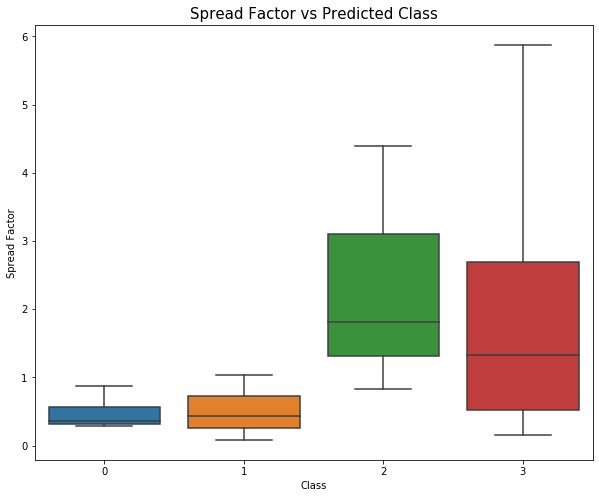

In [32]:
# graph box plot to see the groupings visually against spread factor which should determine the risk class level
fig, axes = plt.subplots(figsize = (10,8))
sns.boxplot(x = Y_train_pred['Class'], y = Y_train_pred['Spread Factor'], ax = axes)
plt.title('Spread Factor vs Predicted Class', fontsize = 15)

In the end, we want to assign classifications based on spread factor as this is what will dictate the risk level associated with a region due to COVID-19. However, it seems like each class is overlapping with each other which might indicate an inherent fault with making clusters of 4. Nevertheless, we will make clusterings of 4 based on splitting the spread factor among the quartiles to make 4 classes of risk.

In [33]:
# find the 1/4 quartiles to split data into four pieces

quantile_25 = y_train.quantile(.25)
median = y_train.quantile(.5)
quantile_75 = y_train.quantile(.75)

const = [quantile_25, median, quantile_75]
const

[0.4375532573367206, 0.9819114997978428, 2.3554719650725167]

In [34]:
# function that will assign labels according to the quantiles specified above

def create_labels(df, cons):
    df1 = df.to_frame().copy()
    df1['Class'] = [None]*df1.shape[0]
    df1.loc[(df1['Spread Factor'] < cons[0]), 'Class'] = 'Class 1'
    df1.loc[(df1['Spread Factor'] >= cons[0]) & (df1['Spread Factor'] < cons[1]), 'Class'] = 'Class 2'
    df1.loc[(df1['Spread Factor'] >= cons[1]) & (df1['Spread Factor'] < cons[2]), 'Class'] = 'Class 3'
    df1.loc[df1['Spread Factor'] >= cons[2], 'Class'] = 'Class 4'
    return df1['Class']

In [35]:
# include the assigned labels with train feature matrix
X_train_top_3_with_class = X_train_top_3.copy()
X_train_top_3_with_class['Class'] = create_labels(y_train, const)

In [36]:
X_train_top_3_with_class.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010  \
517     -0.459746              -0.085970                       -0.539807   
409      0.168200              -0.582484                       -0.211527   
495     -0.773719              -0.246136                        0.114197   
150      3.307928              -0.583046                       -0.109455   
386      0.168200               1.729591                        3.795025   

       Class  
517  Class 2  
409  Class 4  
495  Class 3  
150  Class 1  
386  Class 3

In [37]:
# include the assignd labels with the test feature matrix
X_test_top_3_with_class = X_test_top_3.copy()
X_test_top_3_with_class['Class'] = create_labels(y_test, const)

In [38]:
X_test_top_3_with_class.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010  \
349     -0.205246              -0.909178                       -0.651544   
24       2.209408               2.159338                       -0.592694   
229     -0.808909              -0.969244                       -0.424980   
370      1.907576              -0.158294                        0.071576   
163      0.096586               0.307778                       -0.026197   

       Class  
349  Class 3  
24   Class 1  
229  Class 2  
370  Class 2  
163  Class 1

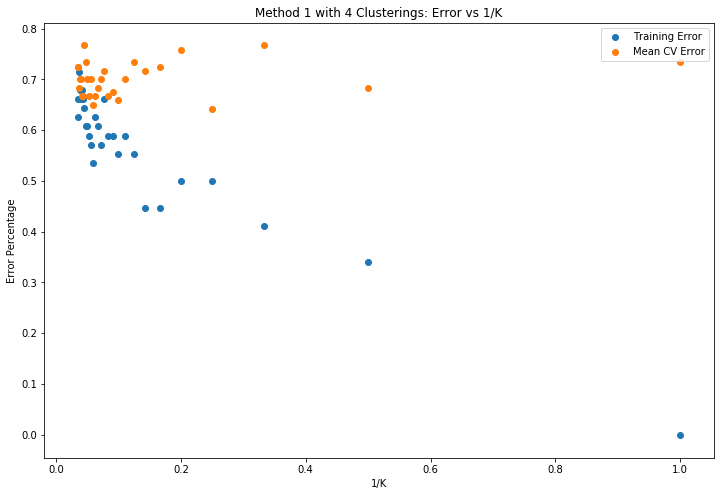

In [39]:
# try implementing k nearest neighbors machine learning alg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

k_val = np.arange(1,30)
train_error = [None]*len(k_val)
cv_error = [None]*len(k_val)
for ind, ele in enumerate(k_val):
    neigh = KNeighborsClassifier(n_neighbors = ele)
    neigh.fit(X_train_top_3_with_class.iloc[:,:3], X_train_top_3_with_class.iloc[:,3])
    train_predict = neigh.predict(X_train_top_3_with_class.iloc[:,:3])
    train_error[ind] = 1 - accuracy_score(X_train_top_3_with_class.iloc[:,3], train_predict)
    cv_scores = cross_val_score(neigh, X_train_top_3_with_class.iloc[:,:3], X_train_top_3_with_class.iloc[:,3], cv=5)
    cv_error[ind] = 1 - np.mean(cv_scores)
    
inv_k = 1/k_val

fig, axes = plt.subplots(figsize = (12,8))
plt.scatter(inv_k, train_error, label = 'Training Error')
plt.scatter(inv_k, cv_error, label = 'Mean CV Error')
plt.title('Method 1 with 4 Clusterings: Error vs 1/K')
plt.xlabel('1/K')
plt.ylabel('Error Percentage')
plt.legend()

From this graph alone, we can see that the KNN classifier is essentially unreliable with the current method as error percentages from cross validation are around 70%. Perhaps, the number of clusterings we made is too high and lets try 2 clustering groups instead.

In [40]:
# find the median quartile to split data into two groups: low vs high risk

const = [y_train.quantile(.5)]
const

[0.9819114997978428]

In [41]:
# function that will assign labels according to the quantiles specified above

def create_labels_v_2(df, cons):
    df1 = df.to_frame().copy()
    df1['Class'] = [None]*df1.shape[0]
    df1.loc[(df1['Spread Factor'] < cons[0]), 'Class'] = 'Low Risk'
    df1.loc[df1['Spread Factor'] >= cons[0], 'Class'] = 'High Risk'
    return df1['Class']

In [42]:
X_train_top_3_class_v_2 = X_train_top_3.copy()
X_train_top_3_class_v_2['Class'] = create_labels_v_2(y_train, const)

In [43]:
X_train_top_3_class_v_2.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010  \
517     -0.459746              -0.085970                       -0.539807   
409      0.168200              -0.582484                       -0.211527   
495     -0.773719              -0.246136                        0.114197   
150      3.307928              -0.583046                       -0.109455   
386      0.168200               1.729591                        3.795025   

         Class  
517   Low Risk  
409  High Risk  
495  High Risk  
150   Low Risk  
386  High Risk

In [44]:
X_test_top_3_class_v_2 = X_test_top_3.copy()
X_test_top_3_class_v_2['Class'] = create_labels_v_2(y_test, const)

In [45]:
X_test_top_3_class_v_2.head()

stay at home  #FTEHospitalTotal2017  PopulationDensityperSqMile2010  \
349     -0.205246              -0.909178                       -0.651544   
24       2.209408               2.159338                       -0.592694   
229     -0.808909              -0.969244                       -0.424980   
370      1.907576              -0.158294                        0.071576   
163      0.096586               0.307778                       -0.026197   

         Class  
349  High Risk  
24    Low Risk  
229   Low Risk  
370   Low Risk  
163   Low Risk

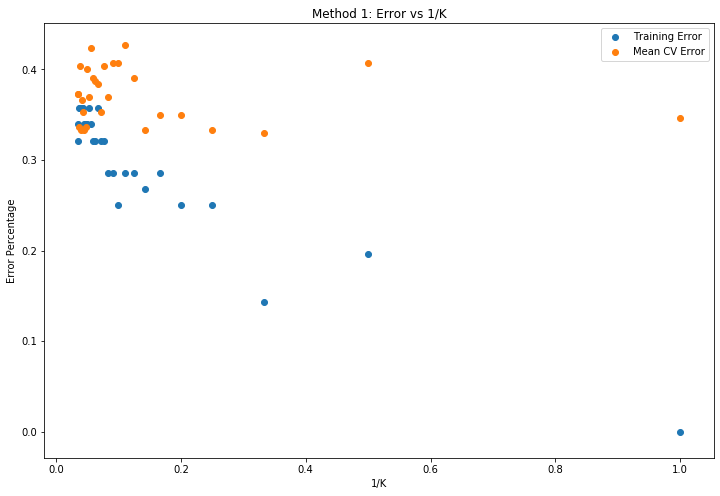

In [46]:
# implement knn with 2 clusterings now

k_val = np.arange(1,30)
train_error = [None]*len(k_val)
cv_error = [None]*len(k_val)
for ind, ele in enumerate(k_val):
    neigh = KNeighborsClassifier(n_neighbors = ele)
    neigh.fit(X_train_top_3_class_v_2.iloc[:,:3], X_train_top_3_class_v_2.iloc[:,3])
    train_predict = neigh.predict(X_train_top_3_class_v_2.iloc[:,:3])
    train_error[ind] = 1 - accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
    cv_scores = cross_val_score(neigh, X_train_top_3_class_v_2.iloc[:,:3], X_train_top_3_class_v_2.iloc[:,3], cv=5)
    cv_error[ind] = 1 - np.mean(cv_scores)
    
inv_k = 1/k_val

fig, axes = plt.subplots(figsize = (12,8))
plt.scatter(inv_k, train_error, label = 'Training Error')
plt.scatter(inv_k, cv_error, label = 'Mean CV Error')
plt.title('Method 1: Error vs 1/K')
plt.xlabel('1/K')
plt.ylabel('Error Percentage')
plt.legend()

In [47]:
# figuring out the optimal k-value that minimizes error

smallest_cv_error = min(cv_error)
index = cv_error.index(smallest_cv_error)
k_opt = k_val[index]
train_err_spec = train_error[index]

print(f'Optimal value of k is {k_opt}')
print(f'The respective cv error is {smallest_cv_error}')
print(f'Respective train error is {train_err_spec}')

Optimal value of k is 3
The respective cv error is 0.33000000000000007
Respective train error is 0.1428571428571429


In [48]:
# create final_model with optimal k with clusterings of 2 and test on test set

final_model = KNeighborsClassifier(n_neighbors = 3)
final_model.fit(X_train_top_3_class_v_2.iloc[:,:3], X_train_top_3_class_v_2.iloc[:,3])
train_predict = final_model.predict(X_train_top_3_class_v_2.iloc[:,:3])
test_predict = final_model.predict(X_test_top_3_class_v_2.iloc[:,:3])

train_accuracy = accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
test_accuracy = accuracy_score(X_test_top_3_class_v_2.iloc[:,3], test_predict)


train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# assign predictions
X_train_top_3_class_v_2['Predictions'] = train_predict
X_test_top_3_class_v_2['Predictions'] = test_predict

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


Training Accuracy: 0.8571428571428571
Test Accuracy: 0.6


Seems like 2 clusterings provides more reliable results so we will stick with 2 clusterings for the rest of the classification analysis.

In [49]:
# actual assigned classes for training model
fig = px.scatter_3d(X_train_top_3_class_v_2, x='stay at home', y='#FTEHospitalTotal2017', z='PopulationDensityperSqMile2010',
              color='Class')
fig.show()

In [50]:
# predictions for the trained model
fig = px.scatter_3d(X_train_top_3_class_v_2, x='stay at home', y='#FTEHospitalTotal2017', z='PopulationDensityperSqMile2010',
              color='Predictions')
fig.show()

In [51]:
# actual assigned classes for test model
fig = px.scatter_3d(X_test_top_3_class_v_2, x='stay at home', y='#FTEHospitalTotal2017', z='PopulationDensityperSqMile2010',
              color='Class', color_discrete_sequence=["red", "blue"])
fig.show()

In [52]:
# predicted classes for test model
fig = px.scatter_3d(X_test_top_3_class_v_2, x='stay at home', y='#FTEHospitalTotal2017', z='PopulationDensityperSqMile2010',
              color='Predictions', color_discrete_sequence=["red", "blue"])
fig.show()

# Classification Analysis Method 2: Performing PCA and Using the First 3 Components

This method will be similar to the methods above but we will be using the first 3 PCA components for training purposes now.

In [53]:
# do pca on X_train_less
from sklearn.decomposition import PCA

pca = PCA()
principalComponents = pca.fit_transform(X_train_less)
PCA_components = pd.DataFrame(principalComponents, columns = [f'PCA{i}' for i in range(principalComponents.shape[1])])

In [54]:
#take the first 3 components of PCA
PCA_train_3 = PCA_components.iloc[:,:3]
PCA_train_3.head()

PCA0      PCA1      PCA2
0 -0.891409 -1.248431  0.981480
1 -1.342522  1.054180 -1.094453
2 -0.143085 -0.804164  0.937979
3 -0.764716  1.447886 -1.144893
4  3.365023  0.457141 -0.484162

In [55]:
# do pca of X_test_less
pca_1 = PCA()
principalComp = pca.fit_transform(X_test_less)
PCA_comp_test = pd.DataFrame(principalComp, columns = [f'PCA{i}' for i in range(principalComp.shape[1])])

In [56]:
# take the first 3 components of PCA
PCA_test_3 = PCA_comp_test.iloc[:,:3]
PCA_test_3.head()

PCA0      PCA1      PCA2
0 -1.143050 -0.719294 -1.644626
1  3.609291 -1.029274  0.267986
2 -0.324790 -1.027902 -0.995909
3 -0.423201  0.674656 -1.226335
4  1.952422 -1.361495 -1.112736

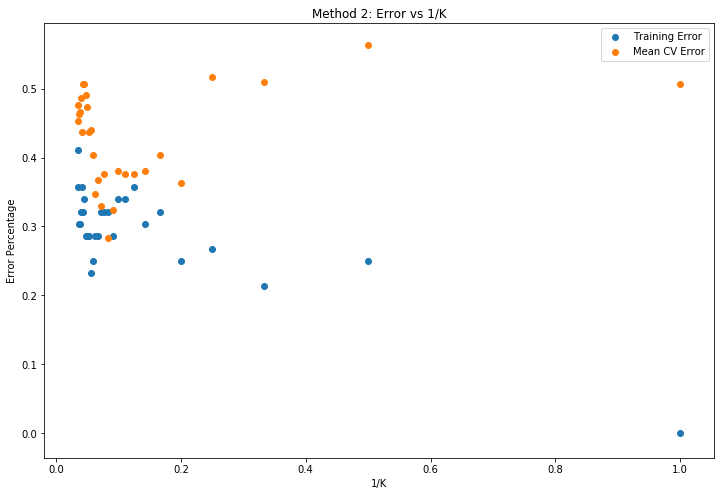

In [57]:
# try implementing k nearest neighbors machine learning alg based on pca 
k_val = np.arange(1,30)
train_error = [None]*len(k_val)
cv_error = [None]*len(k_val)
for ind, ele in enumerate(k_val):
    neigh = KNeighborsClassifier(n_neighbors = ele)
    neigh.fit(PCA_train_3, X_train_top_3_class_v_2.iloc[:,3])
    train_predict = neigh.predict(PCA_train_3)
    train_error[ind] = 1 - accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
    cv_scores = cross_val_score(neigh, PCA_train_3, X_train_top_3_class_v_2.iloc[:,3], cv=5)
    cv_error[ind] = 1 - np.mean(cv_scores)
    
inv_k = 1/k_val

fig, axes = plt.subplots(figsize = (12,8))
plt.scatter(inv_k, train_error, label = 'Training Error')
plt.scatter(inv_k, cv_error, label = 'Mean CV Error')
plt.title('Method 2: Error vs 1/K')
plt.xlabel('1/K')
plt.ylabel('Error Percentage')
plt.legend()

In [58]:
# figuring out the optimal k-value that minimizes error based on top 3 pca

smallest_cv_error = min(cv_error)
index = cv_error.index(smallest_cv_error)
k_opt = k_val[index]
train_err_spec = train_error[index]

print(f'Optimal value of k is {k_opt}')
print(f'The respective cv error is {smallest_cv_error}')
print(f'Respective train error is {train_err_spec}')

Optimal value of k is 12
The respective cv error is 0.28333333333333344
Respective train error is 0.3214285714285714


In [59]:
# results for classifications based on pca

final_model = KNeighborsClassifier(n_neighbors = 12)
final_model.fit(PCA_train_3, X_train_top_3_class_v_2.iloc[:,3])
train_predict = final_model.predict(PCA_train_3)
test_predict = final_model.predict(PCA_test_3)

train_accuracy = accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
test_accuracy = accuracy_score(X_test_top_3_class_v_2.iloc[:,3], test_predict)


train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# assign predictions
PCA_train_3['Predictions'] = train_predict
PCA_test_3['Predictions'] = test_predict

#assign classes
PCA_train_3['Class'] = X_train_top_3_class_v_2.iloc[:,3].reset_index(drop= True)
PCA_test_3['Class'] = X_test_top_3_class_v_2.iloc[:,3].reset_index(drop=True)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.6785714285714286
Test Accuracy: 0.48


In [60]:
# actual assigned classes for training model
fig = px.scatter_3d(PCA_train_3, x='PCA0', y='PCA1', z='PCA2', color='Class')
fig.show()

In [61]:
# predicted classes for training model
fig = px.scatter_3d(PCA_train_3, x='PCA0', y='PCA1', z='PCA2', color='Predictions',color_discrete_sequence=["red", "blue"])
fig.show()

In [62]:
# actual assigned classes for testing dataset
fig = px.scatter_3d(PCA_test_3, x='PCA0', y='PCA1', z='PCA2', color='Class', color_discrete_sequence=["red", "blue"])
fig.show()

In [63]:
# predicted classes for testing dataset
fig = px.scatter_3d(PCA_test_3, x='PCA0', y='PCA1', z='PCA2', color='Predictions',)
fig.show()

From the results above, we can see that there is low predicting capaibility if PCA is used and it shows how reliable predictions can not be made based on the first three PCA components.

# Classification Analysis Method 3: Using all Features of Simple Model from Lasso Regression Analysis

This method is similar to the methods before, but now we will be using all the features instead of simplifying the feature matrix to 3 dimensions. 

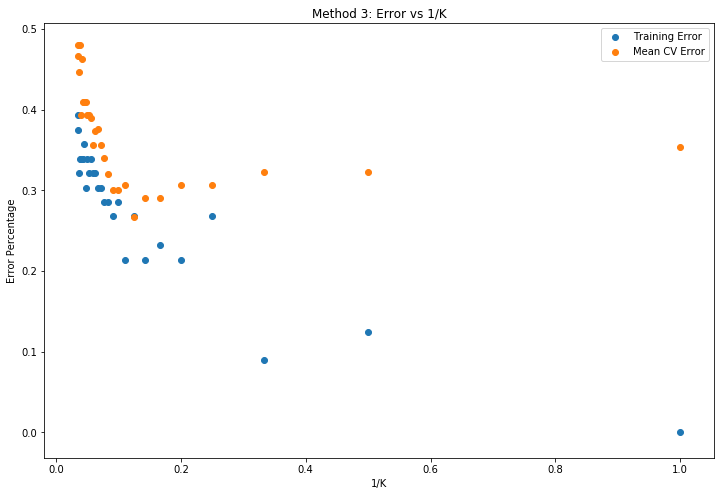

In [64]:
# try using all the features
k_val = np.arange(1,30)
train_error = [None]*len(k_val)
cv_error = [None]*len(k_val)
for ind, ele in enumerate(k_val):
    neigh = KNeighborsClassifier(n_neighbors = ele)
    neigh.fit(X_train_less, X_train_top_3_class_v_2.iloc[:,3])
    train_predict = neigh.predict(X_train_less)
    train_error[ind] = 1 - accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
    cv_scores = cross_val_score(neigh, X_train_less, X_train_top_3_class_v_2.iloc[:,3], cv=5)
    cv_error[ind] = 1 - np.mean(cv_scores)
    
inv_k = 1/k_val

fig, axes = plt.subplots(figsize = (12,8))
plt.scatter(inv_k, train_error, label = 'Training Error')
plt.scatter(inv_k, cv_error, label = 'Mean CV Error')
plt.title('Method 3: Error vs 1/K')
plt.xlabel('1/K')
plt.ylabel('Error Percentage')
plt.legend()

In [65]:
# figuring out the optimal k-value that minimizes error

smallest_cv_error = min(cv_error)
index = cv_error.index(smallest_cv_error)
k_opt = k_val[index]
train_err_spec = train_error[index]

print(f'Optimal value of k is {k_opt}')
print(f'The respective cv error is {smallest_cv_error}')
print(f'Respective train error is {train_err_spec}')

Optimal value of k is 8
The respective cv error is 0.2666666666666666
Respective train error is 0.2678571428571429


In [66]:
# get train accuracy and test accuracy of the most optimized model

final_model = KNeighborsClassifier(n_neighbors = 8)
final_model.fit(X_train_less, X_train_top_3_class_v_2.iloc[:,3])
train_predict = final_model.predict(X_train_less)
test_predict = final_model.predict(X_test_less)

train_accuracy = accuracy_score(X_train_top_3_class_v_2.iloc[:,3], train_predict)
test_accuracy = accuracy_score(X_test_top_3_class_v_2.iloc[:,3], test_predict)


train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.7321428571428571
Test Accuracy: 0.68


We can see that these results are comparable with that of 1st classification method which was based on the top 3 contributing features as decided by the lasso regression model. From this, we can say that perhaps the most useful model would be the first one as it provides the same classification power with less features. 